# Sensitivity analysis


## t-closeness

This analysis uses methodology from Google's paper 
"Measuring Sensitivity of Cohorts Generated by the FLoC API" 
<<a href="https://docs.google.com/a/chromium.org/viewer?a=v&pid=sites&srcid=Y2hyb21pdW0ub3JnfGRldnxneDo1Mzg4MjYzOWI2MzU2NDgw">link</a>>

See section "Utility vs privacy"

![title](../docs/google_t_closeness_analysis.png)



We set up a dummy panel representing the U.S. population w.r.t. size and the joint distribution of our income x race demographic groups.

Census data is from 2017 provided by the CPS:

Table HINC-04. https://www.census.gov/data/tables/time-series/demo/income-poverty/cps-hinc/hinc-04.2017.html

The CPS 2018 Annual Social and Economic Supplement asked participants to report their household income for 2017.

We randomly assign cohort IDs s.t. each cohort has at least k=2000 members.

In [148]:
from datetime import datetime
import random
import sys
sys.path.append('..')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from utils.data import income_groups_4, race_groups

## Panel formation

Make a dummy panel representing the U.S. w.r.t. the joint distribution of the income x race demographic groups.

```
mid, income, race, cohort
```

where
- mid is a fake machine_id

In [143]:
cps_df = (pd.read_csv('../data/CPS-race.csv', usecols=[0,1,2,3,4], 
                      dtype={'income group':str}, 
                      index_col='income group'
                     )[1:] # drop row 0: Total
              # convert formatted numbers to numbers
              .apply(lambda x: pd.to_numeric(x.astype(str).str.replace(",", "")))
         )
# use comscore race codes
cps_df = cps_df.rename(columns={'white alone': 1,
                              'black alone': 2,
                              'asian alone': 3})
# Comscore only uses white,black,asian 
# so we sum across these identities and subtract
# the total to get the 'other' count also present in the comscore data
cps_df[5] = cps_df.total - cps_df[[1,2,3]].sum(axis=1)
cps_df.drop('total', axis=1, inplace=True)

# manually created mapping from CPS categories to the 4 levels
# that we consistently use across comScore and census data.
cps_df['income_code_4'] = [
    1,1,1,1,1,
    2,2,2,2,2,2,2,2,2,2,
    3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,
    4,4,4,4,4,4,4,4,4,4,4,
]
cps_df['income_group_4'] = cps_df['income_code_4'].map(
    income_groups_4
)
cps_df

,1,2,3,5,income_code_4,income_group_4
income group,,,,,,
"Under \$5,000",2739,1186,280,166,1,"less than $25,000"
"\$5,000 to \$9,999",2154,883,107,151,1,"less than $25,000"
"\$10,000 to \$14,999",4142,1274,172,237,1,"less than $25,000"
"\$15,000 to \$19,999",4494,1163,214,176,1,"less than $25,000"
"\$20,000 to \$24,999",4579,1070,217,231,1,"less than $25,000"
"\$25,000 to \$29,999",4333,963,215,227,2,"\$25,000 - $75,000"
"\$30,000 to \$34,999",4575,1103,206,216,2,"\$25,000 - $75,000"
"\$35,000 to \$39,999",4354,948,218,200,2,"\$25,000 - $75,000"
"\$40,000 to \$44,999",3947,763,222,166,2,"\$25,000 - $75,000"


In [144]:
# use our 4 income groups
cps_df = (
    cps_df[[1,2,3,5,'income_group_4']]
    .groupby('income_group_4')
    .agg(sum)
    .rename(race_groups, axis=1) # use our names for race groups
)
cps_df

,white,black,asian,other
income_group_4,,,,
"\$150,000 or more",15981,1113,1700,377
"\$25,000 - $75,000",38045,7145,2092,1642
"\$75,000 - $150,000",27977,3186,1968,809
"less than $25,000",18108,5576,990,961


Extract values for each joint income x race category

In [145]:
census_df = (
    cps_df
    .melt(ignore_index=False, var_name='race', value_name='population')
    .reset_index()
    .rename({'income_group_4':'income'}, axis=1)
)
census_df.head()

,income,race,population
0,"\$150,000 or more",white,15981
1,"\$25,000 - $75,000",white,38045
2,"\$75,000 - $150,000",white,27977
3,"less than $25,000",white,18108
4,"\$150,000 or more",black,1113


We scale the size of the panel to the size of the Google Chrome OT trial.

[According to the Chrome team](https://sites.google.com/a/chromium.org/dev/Home/chromium-privacy/privacy-sandbox/floc), for the OT trial:
- k=2000
- Number of cohorts, before any filtering: 33,872

We might assume that the average cohort size was then 3,000 based on the below analysis

And that there were then ~ 3000 x 33,872 total devices in the trial


#### Estimating origin trial size.

The question is what the cohorts sizes were, or how many total devices were included in the trial.

To estimate this:

We can use our real browsing data, which is a much smaller sample than Google's sample for the OT.

We use our preprocessed browsing history and FLoC PrefixLSH implementation to determine whether there are consistent patterns / relationships between k and the average number and distribution of cohort sizes.

In [4]:
# read in preprocessed browsing data
# weeks,machine,domains,simhash (weeks_machines_domains)

wmd_simhash_fpath = '../output/wmd_simhash.csv'

wmd_df = pd.read_csv(wmd_simhash_fpath)
print('read in %s total rows' % len(wmd_df))
wmd_df.drop('domains', axis=1).head()

read in 4877236 total rows


,machine_id,week,n_domains,simhash
0,169007206,1,104,1.585204e+14
1,170331223,1,0,NaN
2,170422065,1,20,5.322881e+14
3,170911221,1,49,7.213568e+14
4,171771316,1,64,6.710488e+14


Limit data to machine, weeks with sufficient data for cohort generation: >= 7 domains

In [5]:
n_domains_threshold = 7
print('dropping machine weeks with < %s domains' % n_domains_threshold)
wmd_df = wmd_df[wmd_df.n_domains >= n_domains_threshold]
print('%s data rows' % len(wmd_df))

dropping machine weeks with < 7 domains
2073405 data rows


In [6]:
import prefixLSH

cohort_ks = [2000,1000,500,250,125]

for k in cohort_ks:
    print('computing cohorts for k=%s' % k)
    t_start = datetime.now()
    cohorts_dict = prefixLSH.get_cohorts_dict(wmd_df.simhash.astype(int), min_k=k)
    wmd_df['cohort_%s'%k] = wmd_df.simhash.map(cohorts_dict)
    print('took %s' % (datetime.now() - t_start))

computing cohorts for k=2000
took 0:00:30.578845
computing cohorts for k=1000
took 0:00:41.003423
computing cohorts for k=500
took 0:01:02.507255
computing cohorts for k=250
took 0:01:51.886525
computing cohorts for k=125
took 0:03:14.421514


In [7]:
wmd_df.head(3)

,machine_id,week,n_domains,domains,simhash,cohort_2000,cohort_1000,cohort_500,cohort_250,cohort_125
0,169007206,1,104,"{'2dopeboyz.com', 'offers.com', 'wordpress.com...",1.585204e+14,83,165,316,667,1337
2,170422065,1,20,"{'shein.com', 'refinery29.com', 'messenger.com...",5.322881e+14,263,533,1012,2141,4306
3,170911221,1,49,"{'8haodangpu.cc', 'vjav.com', '51luoben.com', ...",7.213568e+14,381,754,1468,3088,6242



k=2000: 664.0 total cohorts; mean cohort size = 3122.60
mean cohort size / k = 1.56

k=1000: 1279.0 total cohorts; mean cohort size = 1621.11
mean cohort size / k = 1.62

k=500: 2562.0 total cohorts; mean cohort size = 809.29
mean cohort size / k = 1.62

k=250: 5403.0 total cohorts; mean cohort size = 383.75
mean cohort size / k = 1.54

k=125: 10800.0 total cohorts; mean cohort size = 191.98
mean cohort size / k = 1.54


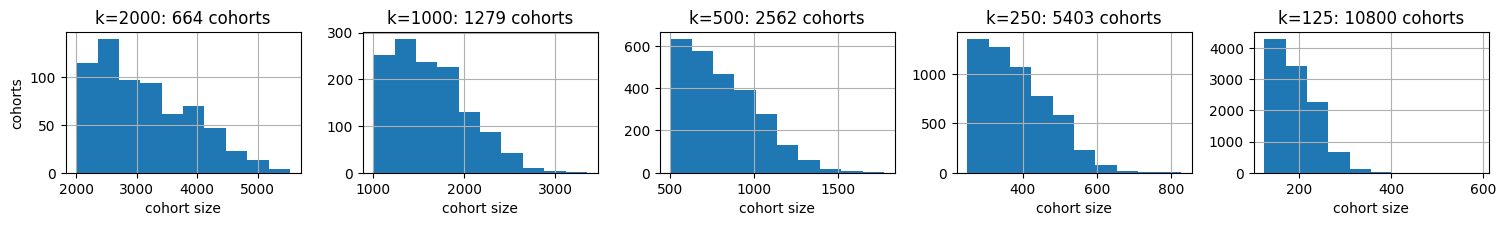

In [8]:
ks = len(cohort_ks)
fig, axes = plt.subplots(1, ks, figsize=(ks*3, 2), dpi=100)
plt.tight_layout()

for i, k in enumerate(cohort_ks):
    ax = axes[i]
    value_counts = wmd_df['cohort_%s'%k].value_counts()
    value_counts_d = value_counts.describe()
    print('\nk=%s: %s total cohorts; mean cohort size = %0.2f' % (
        k, value_counts_d['count'], value_counts_d['mean']
    ))
    # print(value_counts_d)
    value_counts.hist(ax=ax)
    ax.set_title('k=%s: %s cohorts' % (
        k, int(value_counts_d['count'])))
    ax.set_xlabel("cohort size")
    print('mean cohort size / k = %0.2f' %(value_counts_d['mean']/k))
_ = axes[0].set_ylabel("cohorts")
plt.show()


We might assume that the average cohort size was 3,000 (k=2000 x 1.5) based on the above analysis

And that there were then ~ 3000 x 33,872 total devices in the trial

In [37]:
total_population_estimate = census_df.population.sum()
total_population_estimate # note this is population of households

127670

In [38]:
OT_cohort_N = 33872
OT_mid_N = OT_cohort_N*3000
print('OT_mid_N:', OT_mid_N)
print('OT_mid_N / total population = %s / %s = %0.3f' % (
    OT_mid_N, total_population_estimate, OT_mid_N/total_population_estimate
))

OT_mid_N: 101616000
OT_mid_N / total population = 101616000 / 127670 = 795.927


### Random OT panel creation

In [48]:
census_df['OT_scaled_population'] = (census_df.population * (OT_mid_N/total_population_estimate)).apply(round)
print('OT total population = %s' % census_df['OT_scaled_population'].sum())
census_df.head()

OT total population = 101615999


,income,race,population,OT_scaled_population
0,"\$150,000 or more",white,15981,12719709
1,"\$25,000 - $75,000",white,38045,30281043
2,"\$75,000 - $150,000",white,27977,22267650
3,"less than $25,000",white,18108,14412646
4,"\$150,000 or more",black,1113,885867


In [57]:
# create a list of income,race combos representing panel
# i.e. one income,race combo per individual in the population
census_demo_count_dict = census_df.set_index(
    ['income','race']
)['OT_scaled_population'].to_dict()
demos = [[d]*c for (d, c) in census_demo_count_dict.items()]
demos = [d for d_c in demos for d in d_c]

In [59]:
demos[:3]

[('\\$150,000 or more', 'white'),
 ('\\$150,000 or more', 'white'),
 ('\\$150,000 or more', 'white')]

In [12]:
random.seed(0)

In [111]:
# create list of cohort IDs
# representing the 33,872 cohorts from the origin trial
# where each cohort has minimum k=2000

k=2000

def get_cohorts_random_uniform(N, k=k, cohorts=OT_cohort_N):
    """
    Returns series of cohort IDs uniformly randomly assigned.
    Each cohort has size >= k
    """
    if N < (k*cohorts): # allow for a rounding error
        raise Exception('N must be larger than k x number of cohorts')
    cohort_ids = list(range(cohorts))*k
    cohort_ids += list(np.random.randint(cohorts, size=(N - len(cohort_ids))))
    return pd.Series(cohort_ids) + 1

In [112]:
def get_OT_random_panel_cohorts_df(demo_groups, N=OT_mid_N):
    """
    Returns panel mapping (fake) machine ids (mid) to 
    cohort and demographic group.
    Distribution of demographic group values matches true population.
    Size and number of cohorts in the panel matches the Google Chrome 
    origin trial (OT). 
    Yet cohorts are randomly distributed.
    """
    if len(demo_groups) < (N-1): # allow for a rounding error
        raise Exception('number of values for demographic groups must match N')
    N = len(demo_groups)
    cohort_ids = get_cohorts_random_uniform(N)
    mid = list(range(N))
    random.shuffle(mid)
    panel_df = pd.DataFrame({
        'mid': mid,
        'cohort': cohort_ids,
    }).sort_values('mid')
    panel_df[['income', 'race']] = demo_groups
    return panel_df

In [ ]:
panel_df = get_OT_random_panel_cohorts_df(demos)

In [115]:
len(panel_df)

101615999

In [116]:
panel_df.head()

,mid,cohort,income,race
44700500,0,23333,"\$150,000 or more",white
95872270,1,355,"\$150,000 or more",white
51706568,2,17897,"\$150,000 or more",white
81739239,3,11824,"\$150,000 or more",white
99585373,4,15800,"\$150,000 or more",white


In [117]:
panel_df.cohort.nunique()

33872

In [118]:
panel_df.cohort.value_counts().describe()

count    33872.000000
mean      2999.999970
std         31.594842
min       2870.000000
25%       2978.000000
50%       3000.000000
75%       3021.000000
max       3147.000000
Name: cohort, dtype: float64

## Panel analysis

### Race

In [119]:
panel_df.head()

,mid,cohort,income,race
44700500,0,23333,"\$150,000 or more",white
95872270,1,355,"\$150,000 or more",white
51706568,2,17897,"\$150,000 or more",white
81739239,3,11824,"\$150,000 or more",white
99585373,4,15800,"\$150,000 or more",white


In [120]:
cohort_race_counts_df = panel_df.groupby(
    ['cohort','race']
).count()['mid'].rename('count').to_frame().reset_index('race')
cohort_race_counts_df.head()

,race,count
cohort,,
1,asian,155
1,black,419
1,other,84
1,white,2365
2,asian,140


In [121]:
cohort_race_counts_df['total'] = panel_df.groupby('cohort').count().mid
cohort_race_counts_df['portion'] = cohort_race_counts_df['count']/cohort_race_counts_df['total']
cohort_race_counts_df.head(10)

,race,count,total,portion
cohort,,,,
1,asian,155,3023,0.051274
1,black,419,3023,0.138604
1,other,84,3023,0.027787
1,white,2365,3023,0.782335
2,asian,140,2959,0.047313
2,black,379,2959,0.128084
2,other,85,2959,0.028726
2,white,2355,2959,0.795877
3,asian,168,2952,0.056911


In [163]:
races = ['white', 'black', 'asian', 'other']
income_groups = list(income_groups_4.values())

In [172]:
from style_config import BLUE

t=0.1
dpi=500


def plot_cohort_demo_fractions(p_df, demo_col, demo_names,
                              t=t, dpi=dpi, 
                               # plot random sample of cohorts
                               sample_N=1000):
    fig, axes = plt.subplots(1, len(demo_names),
                             figsize=(3*len(demo_names),2.5), dpi=dpi)
    axes[0].set_ylabel('Fraction')
    plt.tight_layout()

    for i, demo in enumerate(demo_names):
        print('\n%s: %s' % (demo_col, demo))
        panel_fraction = len(panel_df[panel_df[demo_col]==demo])/len(panel_df)
        print('panel fraction: %0.2f' % panel_fraction)
        ax = axes[i]
        portions = p_df[(p_df[demo_col]==demo)].portion
        print(portions.describe())
        portions_sample = pd.Series(np.random.choice(portions, size=sample_N))
        portions_sample.sort_values(ascending=False).plot.bar(ax=ax, label="", color=BLUE)
        ax.hlines(y=panel_fraction, xmin=0, xmax=len(ax.get_xticks()), 
                  linestyles='-', color='black', label='mean')
        ax.hlines(y=panel_fraction+t, xmin=0, xmax=len(ax.get_xticks()), 
                  linestyles='--', color='black', label='mean + t=0.1')
        ax.set_xticks([])
        ax.set_xlabel('%s sampled cohorts' % sample_N)
        ax.set_title('%s' % demo.capitalize())


race: white
panel fraction: 0.78
count    33872.000000
mean         0.784139
std          0.007467
min          0.751669
25%          0.779139
50%          0.784166
75%          0.789195
max          0.814988
Name: portion, dtype: float64

race: black
panel fraction: 0.13
count    33872.000000
mean         0.133312
std          0.006145
min          0.111471
25%          0.129183
50%          0.133245
75%          0.137438
max          0.160362
Name: portion, dtype: float64

race: asian
panel fraction: 0.05
count    33872.000000
mean         0.052871
std          0.004079
min          0.037566
25%          0.050099
50%          0.052809
75%          0.055593
max          0.068897
Name: portion, dtype: float64

race: other
panel fraction: 0.03
count    33872.000000
mean         0.029678
std          0.003069
min          0.018152
25%          0.027593
50%          0.029610
75%          0.031725
max          0.043029
Name: portion, dtype: float64


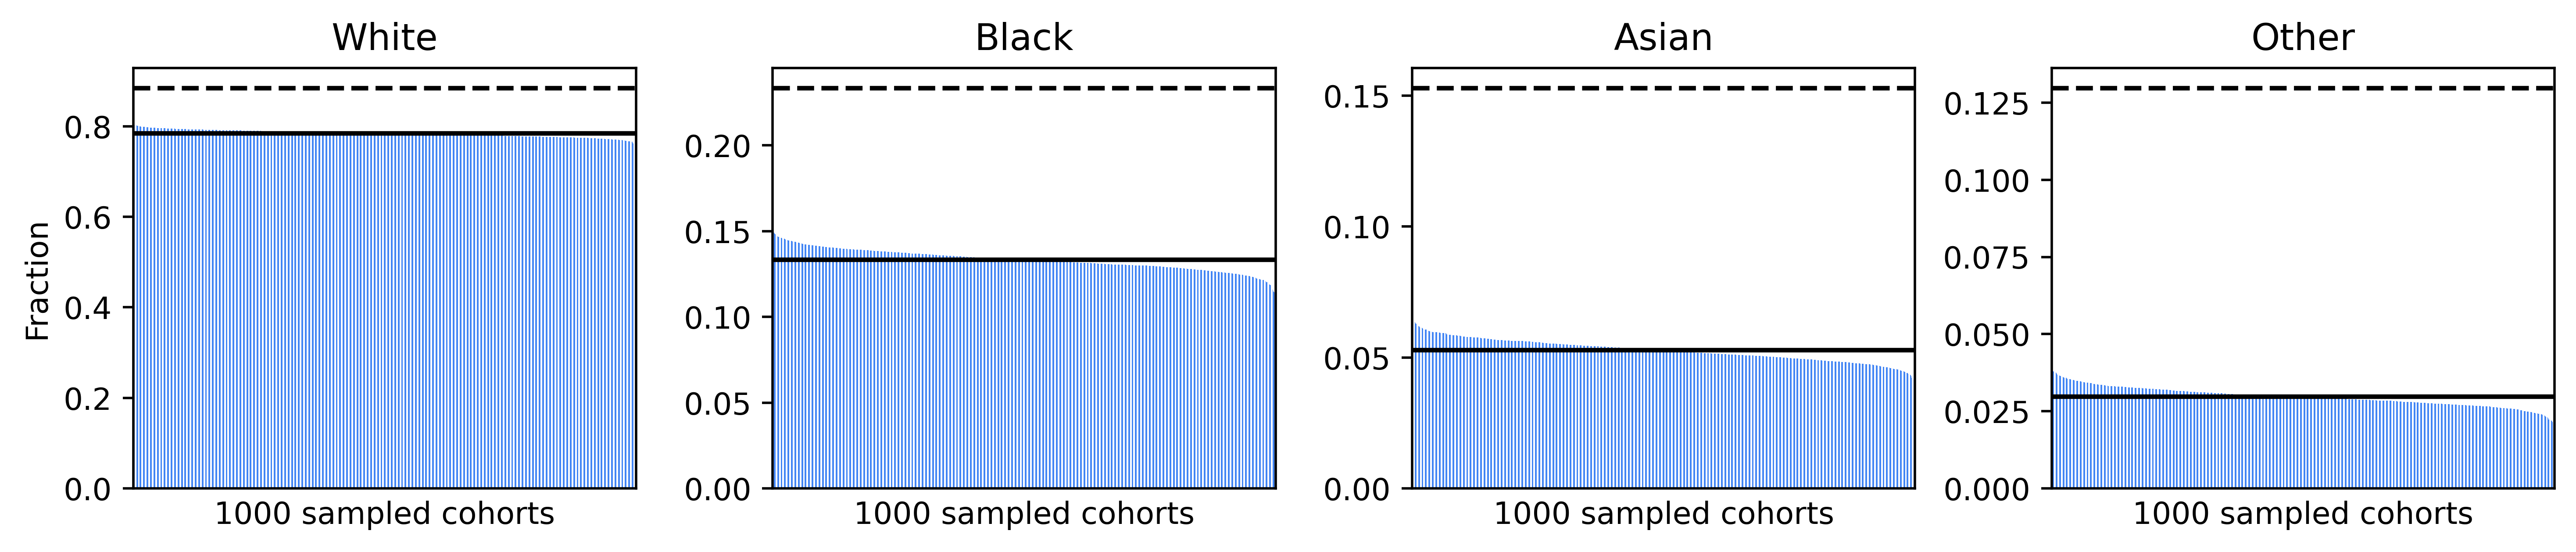

In [173]:
plot_cohort_demo_fractions(cohort_race_counts_df, 'race', races)

### Income groups

In [174]:
cohort_income_counts_df = panel_df.groupby(
    ['cohort','income']
).count()['mid'].rename('count').to_frame().reset_index('income')
cohort_income_counts_df['total'] = panel_df.groupby('cohort').count().mid
cohort_income_counts_df['portion'] = cohort_income_counts_df['count']/cohort_income_counts_df['total']
cohort_income_counts_df.head(10)

,income,count,total,portion
cohort,,,,
1,"\$150,000 or more",451,3023,0.149190
1,"\$25,000 - $75,000",1194,3023,0.394972
1,"\$75,000 - $150,000",791,3023,0.261661
1,"less than $25,000",587,3023,0.194178
2,"\$150,000 or more",461,2959,0.155796
2,"\$25,000 - $75,000",1114,2959,0.376479
2,"\$75,000 - $150,000",824,2959,0.278472
2,"less than $25,000",560,2959,0.189253
3,"\$150,000 or more",402,2952,0.136179



income: less than $25,000
panel fraction: 0.20
count    33872.000000
mean         0.200791
std          0.007312
min          0.171751
25%          0.195797
50%          0.200765
75%          0.205729
max          0.231378
Name: portion, dtype: float64

income: \$25,000 - $75,000
panel fraction: 0.38
count    33872.000000
mean         0.383206
std          0.008870
min          0.348545
25%          0.377219
50%          0.383152
75%          0.389184
max          0.422540
Name: portion, dtype: float64

income: \$75,000 - $150,000
panel fraction: 0.27
count    33872.000000
mean         0.265842
std          0.008062
min          0.234478
25%          0.260343
50%          0.265857
75%          0.271232
max          0.298112
Name: portion, dtype: float64

income: \$150,000 or more
panel fraction: 0.15
count    33872.000000
mean         0.150161
std          0.006506
min          0.123102
25%          0.145715
50%          0.150134
75%          0.154512
max          0.178775
Name: porti

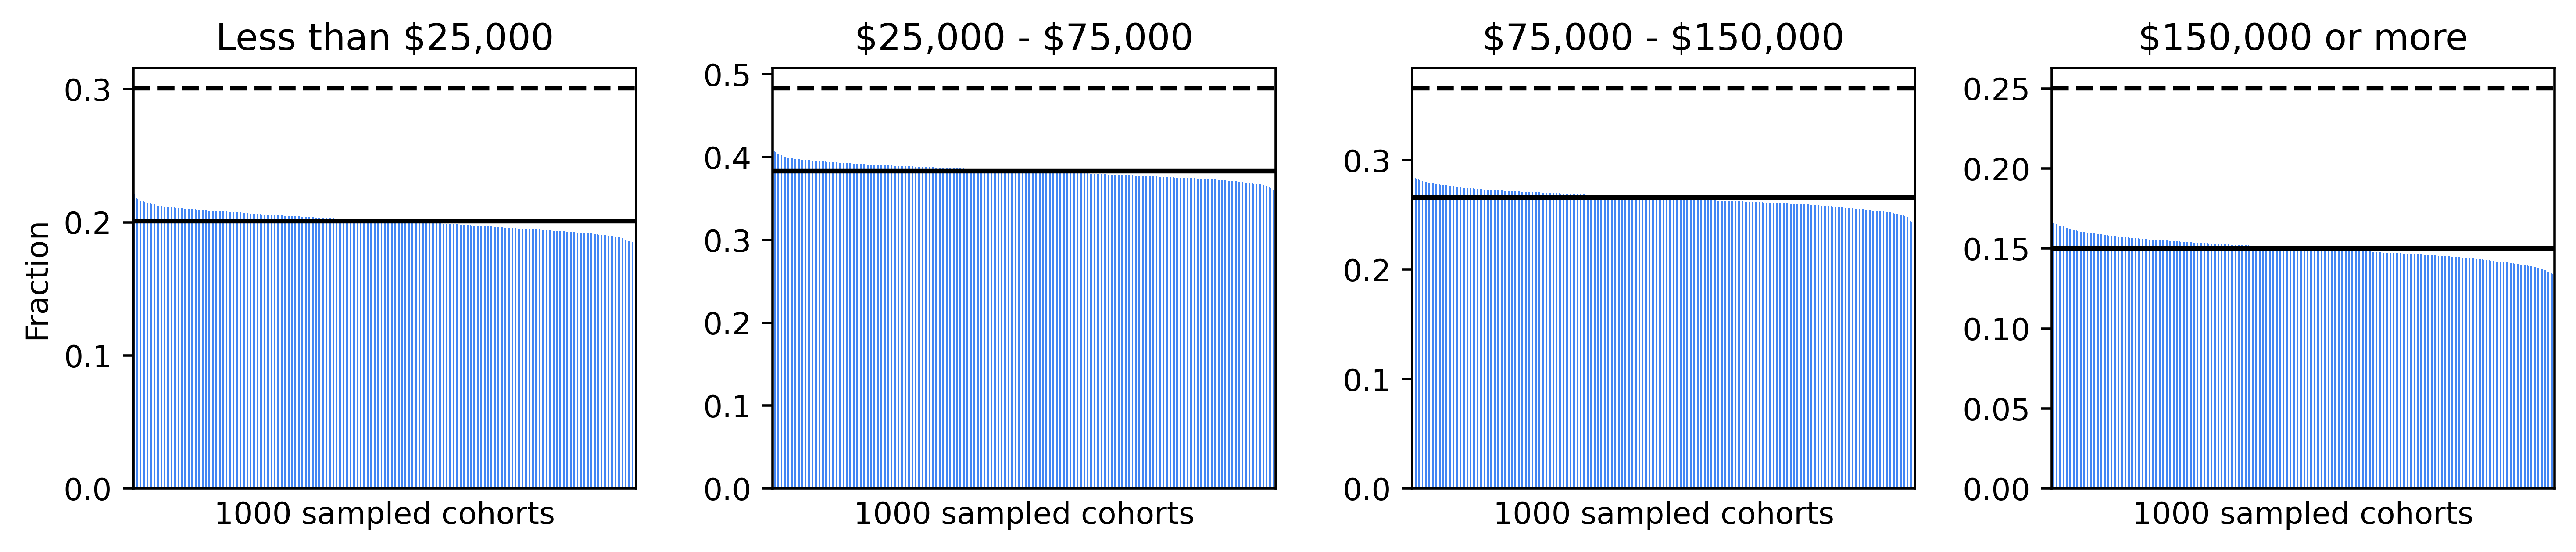

In [175]:
plot_cohort_demo_fractions(cohort_income_counts_df, 'income', income_groups)